# Lab Assignment Three: Exploring Image Data  

$$ Members: Rongxiao Huang,   Zee Liu,   Hua Zong $$

<a id="top"></a>
## Contents
* <a href="#BU">1. Business Understanding</a>
* <a href="#DP">2. Data Preparation</a>
* <a href="#DR">3. Data Reduction</a>
* <a href="#EX">4. Biplot</a>
* <a href="#RE">Reference </a>

___
<a id="BU"></a>
<a href="#top">Back to Top</a>
## 1. Business Understanding 

#### ** An overview of the dataset:
`CIFAR-10` is an established computer-vision dataset used for object recognition. Its train set is a subset of the 80 million tiny images dataset and consists of **50,000 32x32 color images containing one of 10 object classes**, with 5000 images per class. It was collected by `Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton`. 
- https://www.kaggle.com/c/cifar-10
 
#### ** The purpose of the data set selected:
We want to classify the images and attach a label to each image. But in this lab, we are going to explore the image data and compare the results of different feature extraction methods.
 
#### ** Why is this data important?
There is a giant number of images on line. They need to be grouped together according to their target classes for **information management**. This data is for the learning purpose by comparing different methods in dealing with low quality images (small number of pixels).
 
#### ** How will you know if you have gathered useful knowledge from the dataset?
We first convert the RGB images into grayscale. Then, we get the eigen images by using PCA and kernal PCA. We also perform feature extraction upon images by using Daisy and Gabor Kernels. Finally, we compare the results of these two methods by exploring the images selected. This provides a general idea about how well different feature extraction methods perform in the classification task.

If the features extracted are representative and they are good classifiers, we would observe the colored boxes which indicate lowest distances in the diagonal line (after grouping the instances together) from a **heat map** which shows the pairwise distances in features. While other space shows totally different color compared to the diagonal boxes.

We could also create a **contingency table** counting the number of instances correctly classified in each class, and calculating specificity, sensitivity, prevalence, accuracy, diagnostic odd ratio and etc.

<a id="DP"></a>
<a href="#top">Back to Top</a>
## 2. Data Preparation 

### 2.1 Data Input and Transformation

Since there are 50,000 images in the data set, we performed **stratified sampling to obtain a subset of 5000 images**. This would avoid the enormous burden of doing extensive computation. Then we converted the colored images into grayscale because we value the shape much more than the color.

In [1]:
# import the labels, used as classes
import pandas as pd

df_labels = pd.read_csv("C:/Users/zongh/Desktop/2017 Spring/Machine Learning/Lab3/Data/trainLabels.csv") 

# count the number of classes
print('The classes: \n', set(df_labels['label']))
print('The number of classes:', len(set(df_labels['label'])))

The classes: 
 {'horse', 'airplane', 'cat', 'ship', 'automobile', 'frog', 'dog', 'bird', 'truck', 'deer'}
The number of classes: 10


In [2]:
# draw a stratified sample from the data, since it would take a long time to do kernal pca with 50,000 images
import warnings
warnings.simplefilter('ignore')

import numpy as np
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

categ = df_labels.pop('label')
id_train, id_test, categ_train, categ_test = \
    train_test_split(df_labels, categ, test_size=0.1, random_state=42)

In [3]:
# reorder to group the class together
# create dictionary to link together
label = list(categ_test)
id_list = list(id_test['id'])
sorterIndex = dict(zip(id_list,label))

# sort according to label
id_label = sorted(sorterIndex.items(), key=lambda x:x[1])
# split and return to list
id_list,label = map(list,zip(*id_label))

In [4]:
# import data according to id_list
from scipy import misc

images = []
for i in id_list:
    i = str(i)
    image_path = "C:/Users/zongh/Desktop/2017 Spring/Machine Learning/Lab3/Data/train/"+ i + ".png"
    images.append(misc.imread(image_path))

print('The type of image:', type(images))
print('The number of the samples:', len(images))
print('The shape of the image:', images[0].shape)

The type of image: <class 'list'>
The number of the samples: 5000
The shape of the image: (32, 32, 3)


In [5]:
# recolor images since color should not make much sense in feature extraction
# create a function to define the color mixture for gray
def weightedAverage(pixel):
    return (0.299*pixel[0] + 0.587*pixel[1] + 0.114*pixel[2])/255

# convert to grayscale
images_grey = []

for image in images:
    grey = np.zeros((image.shape[0], image.shape[1]))
    for rownum in range(image.shape[0]):
        for colnum in range(image.shape[1]):
            grey[rownum][colnum] = weightedAverage(image[rownum][colnum])
    images_grey.append(grey)

### 2.2 One-Dimension Transformation

Each feature vector is a giant image with the rows of the image just stacked one after the other into a giant vector. The image sizes are 32 pixels by 32 pixels. This gives us **32x32=1024** pixels per image. So we are using each pixel location in the image as a separate feature.

In [6]:
# image matrix to one dimenstion transformation
# create a matrix to hold all the images
# each row correspond to one image
images_1d = np.zeros((len(images_grey),\
                      images_grey[0].shape[0] * images_grey[0].shape[1]))

for i in range(len(images_grey)):
    images_1d[i] = images_grey[i].ravel()
    
print('The number of features:', images_1d.shape[1])
print('The number of samples:', len(images_1d))

The number of features: 1024
The number of samples: 5000


### 2.3 Image Visualization

We visualized 10 images, which are from differnt classes. (Remember there are total 10 classes in the data.)

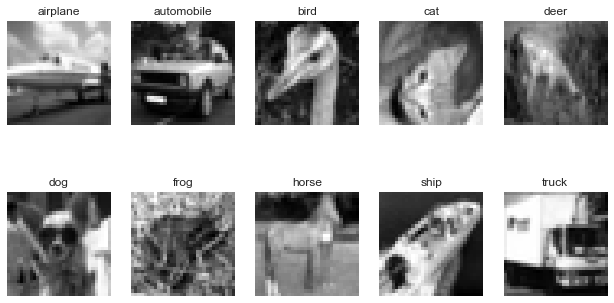

In [7]:
# visualize several images
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=2, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(images_1d[1:5000:550], label[1:5000:550], 32, 32)

<a id="DR"></a>
<a href="#top">Back to Top</a>
## 3. Data Reduction 

### 3.1 PCA

In [28]:
# use full PCA
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenimage from %d image" % (
    n_components, images_1d.shape[0]))

pca = PCA(n_components=n_components)
h, w = images_grey[0].shape
%time pca.fit(images_1d)
eigenimages = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenimage from 5000 image
Wall time: 1.69 s


In [29]:
# visualize the explained variance of each component
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
    
plot_explained_variance(pca)

We have 10 classes of image, so generally speaking we need at least 10 eigen images.
The cumulative explained variance ratio is about 0.70 for the first 10 eigen images.
The cumulative explained variance ratio is about 0.90 for the first 70 eigen images.
(Remember we have 50,000 images in the data set!)

Here, if we require the cumulative explained variance ratio to be 0.80, the first 25 components would be subset as out eigen images.

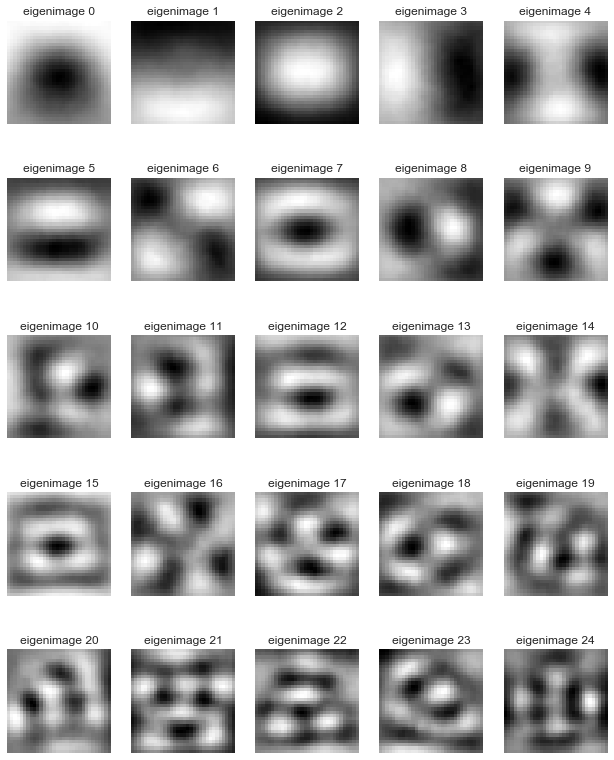

In [30]:
# plot the 25 eigen images
eigenimage_titles = ["eigenimage %d" % i for i in range(eigenimages.shape[0])]
plot_gallery(eigenimages, eigenimage_titles, h, w, 5, 5)

([], <a list of 0 Text yticklabel objects>)

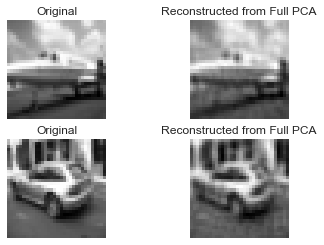

In [31]:
import warnings
warnings.filterwarnings("ignore")

# reconstruct_image from PCA
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 1    
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,images_1d[idx_to_reconstruct])

# plot before and after
plt.subplot(2,2,1)
plt.imshow(images_1d[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.xticks(())
plt.yticks(())
plt.grid()
plt.subplot(2,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.xticks(())
plt.yticks(())
plt.grid()

idx_to_reconstruct = 500
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,images_1d[idx_to_reconstruct])
plt.subplot(2,2,3)
plt.imshow(images_1d[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.xticks(())
plt.yticks(())
plt.grid()
plt.subplot(2,2,4)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid()
plt.xticks(())
plt.yticks(())

### 3.2 Kernal PCA

In [12]:
from sklearn.decomposition import KernelPCA

n_components = 300
print ("Extracting the top %d eigenimages from %d images" % (n_components, images_1d.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=50) # very sensitive to the gamma parameter
%time kpca.fit(images_1d)

Extracting the top 300 eigenimages from 5000 images
Wall time: 29.2 s


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=50, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=300, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)

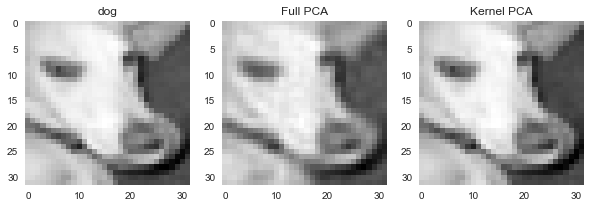

In [32]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets 

# compare the different methods
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(images_1d[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(images_1d[idx_to_reconstruct]))  
    
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1,3,1)
    plt.imshow(images_1d[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(label[idx_to_reconstruct])
    plt.grid()
    
    plt.subplot(1,3,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(1,3,3)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,len(images_1d)-1,1),__manual=True)

For this data set, it seems that both of full and kernel PCA perfom equally well.

idx_to_rec = 3696 (airplane) ---- kernal pca better

idx_to_rec = 802 (horse) ---- kernal pca better

idx_to_rec = 496 (cat) ---- similar

idx_to_rec = 1986 (dog) ---- kernal pca better

idx_to_rec = 2424 (frog) ---- kernal pca better

idx_to_rec = 3476 (ship) ---- kernal pca better

idx_to_rec = 2556 (automobile) ---- full pca better

idx_to_rec = 2117 (truck) ---- kernal pca better

idx_to_rec = 714 (deer) ---- full pca better

idx_to_rec = 1942 (bird) ---- full pca better

It seems like Full PCA and Kernel PCA works similar here.

BUT the pixels in this image dataset is 32*32. It is much smaller than the examples we had in class, which was 125*94. The larger pixels per image would definitely provide more suffiicent information for each image. Similarly, lower pixel size in the image would includ less details and information about the image.

Therefore, in this image dataset there are no significant advantages for Kernel PCA compared the linearized PCA (which is Full PCA here). But for larger images pixel size, the non-linear PCA definitely would have more advantages for image reconstructing. 

### 3.3 Feature Extraction

#### 3.3.1 DAISY

DAISY feature extraction is commonly used in the facial recognition dataset. As there are a lot animals and animal faces (like dog and cat) in this image dataset, DAISY is the first try.

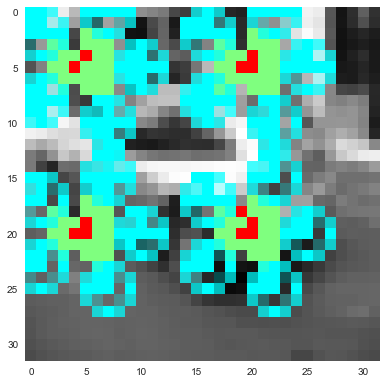

In [14]:
from skimage.io import imshow
from skimage.feature import daisy

img  = images_1d[idx_to_reconstruct].reshape((h,w))

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(img,step=15, radius=5, rings=2, histograms=5, orientations=6, visualize=True)
imshow(img_desc)
plt.grid()

As the pixel size of these images are small, per image is only able to fit less number of histograms, less number of rings, and shorter radius. The image reconstructed from DAISY feature extraction doesn't perform well on the above.

Small pixel size is one reason to explain why the DAISY feature extraction cannot reconstruct a nice image as it has less column for each image and less information could be stored.

Besides, unlike the hand-writing recognition images, the contrast between the subject and the backgroud in CIFAR-10 iamges is not too distinct. The greater contrast in the image would lead to the larger difference of grayscaled value between the pixels. This dataset mainly includes nature scene images and the contrast would be lower betweeen the pixels next to each other. DAISY does work well for facial recognition because faces and facial expression also can have larger contrast wrinkles and lights on the faces.

In [15]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=15, radius=5, rings=2, histograms=5, orientations=6, visualize=False)
    return feat.reshape((-1))

test_feature = apply_daisy(images_1d[3],(h,w))
print ('Number of features are selected by DAISY:', test_feature.shape)

Number of features are selected by DAISY: (264,)


In [16]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, images_1d, (h,w))
print(daisy_features.shape)

Wall time: 8.23 s
(5000, 264)


In [17]:
from sklearn.metrics.pairwise import pairwise_distances

#generate the pairwise distance between all images under DAISY features extraction
dist_matrix_daisy = pairwise_distances(daisy_features)

Although there are 264 features (out of 1024) being selected through DAISY, it may not have distinguish distance difference among the target classes.

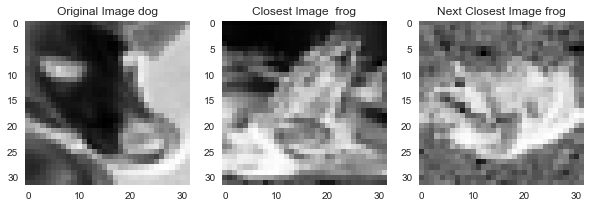

In [18]:
%pylab inline

import copy
import pylab as pl

from ipywidgets import fixed
# put it together inside a nice widget
def closest_image(dmat,idx1):
    import copy
    
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(images_1d[idx1].reshape((h,w)))
    plt.title("Original Image "+label[idx1])
    plt.grid()

    plt.subplot(1,3,2)
    imshow(images_1d[idx2].reshape((h,w)))
    plt.title("Closest Image  "+label[idx2])
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(images_1d[idx3].reshape((h,w)))
    plt.title("Next Closest Image "+label[idx3])
    plt.grid()
    
widgets.interact(closest_image,idx1=(0,len(images_1d)-1,1),dmat=fixed(dist_matrix_daisy),__manual=True)

idx_to_rec = 2499; the origianl is DOG; closest image is FROG; next closest image is FROG

idx_to_rec = 992; the origianl is BIRD; closest image is BIRD; next closest image is BIRD

idx_to_rec = 4106; the origianl is SHIP; closest image is AUTOMOBILE; next closest image is TRUCK

idx_to_rec = 3509; the origianl is HORSE; closest image is FROG; next closest image is HORSE

idx_to_rec = 1568; the origianl is CAT; closest image is CAT; next closest image is CAT

DAISY feature extraction method did a horrible job to find closest and the next coloset image to the original one. In the other words, DAISY did not perform well to differentiate images of the different target classes in this dataset. And the reasons are stated as previous.

#### 3.3.2 Gabor Kernels

Gabor Kernels method is the second try. Gabor Kernel method are usually used in the texture classification. There are a lot nature scenes in the CIFAR-10 dataset. Gabor Kernels might give some surprises.

In [19]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(images_1d))

gabr_feature = compute_gabor(images_1d[idx_to_reconstruct], kernels, (h,w))
print ('Number of features are selected by Gabor Kernal:', gabr_feature.shape)

Number of features are selected by Gabor Kernal: (64,)


In [20]:
# takes ~3 minutes to run entire dataset
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, images_1d, kernels, (h,w))
print(gabor_stats.shape)

Wall time: 1min 36s
(5000, 64)


There are only 64 features selected by the Gabor Kernels method, much less compared to the DAISY.

In [21]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix_gabor= pairwise_distances(gabor_stats)

Wall time: 521 ms


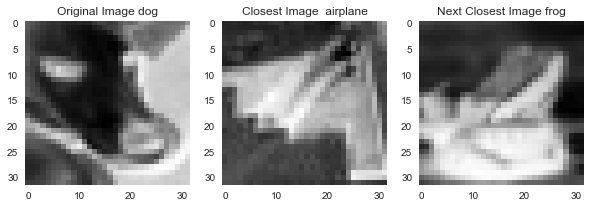

In [22]:
widgets.interact(closest_image,idx1=(0,len(images_1d)-1,1),dmat=fixed(dist_matrix_gabor),__manual=True)

idx_to_rec = 2499; the origianl is DOG; closest image is Airplane; next closest image is FROG

idx_to_rec = 992; the origianl is BIRD; closest image is AUTOMOBILE; next closest image is AUTOMOBILE

idx_to_rec = 4106; the origianl is SHIP; closest image is CAT; next closest image is DOG

idx_to_rec = 3509; the origianl is HORSE; closest image is DOG; next closest image is DEER

idx_to_rec = 1568; the origianl is CAT; closest image is DEER; next closest image is DOG

The "idx_to_rec" number are exactly matching with the examples from DAISY method. Then, it builds a little comparison through a few examples above. Gabor Kernel also didn't perform well to distinguish the different target classes. And it seems worse compared to the Daisy. At least from these examples comparison, DAISY did better to find the closest image and the next closest image.

### 3.4 Differences of Instances

#### 3.4.1 Daisy Standardized Distance Heat Map

In [23]:
from sklearn import preprocessing

daisy_scaled = preprocessing.scale(dist_matrix_daisy)

To have a better scaled value of the pairwise distance through the DAISY method, the pairwised distance matrix is standardized to a normal distribution scale.

Populating the interactive namespace from numpy and matplotlib


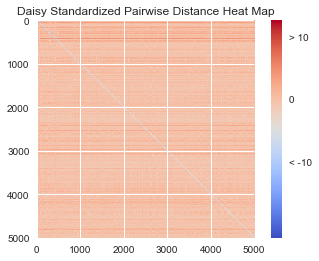

In [24]:
%pylab inline

fig, ax = plt.subplots()

cax = ax.imshow(daisy_scaled, interpolation='nearest', cmap=cm.coolwarm)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[-10, 0, 10])
cbar.ax.set_yticklabels(['< -10', '0', '> 10'])  # vertically oriented colorbar
ax.set_title('Daisy Standardized Pairwise Distance Heat Map')

The data has been sorted in the class variable order.

Ideally, it is expected to see blue color in the diagonal line from letf top corner to the right bottom. And the other area would be in the red. That would represent the distance would be low within the same targeted class while the distance would be high compared to other targeted classes.

From the heat map above, most area is in the light red color. And there is almost no blue area can be observed in this heat map. Therefore, it is not possible to classify the targeted classes with each other.

In the other word, DAISY is not an appropriate feature extraction in this case.

#### 3.4.2 Garbor Kernels Standardized Pairwise Distance Heat Map

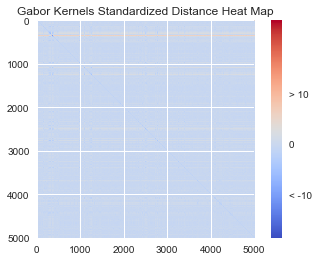

In [25]:
#still perform the standardization as previous
gabor_scaled = preprocessing.scale(dist_matrix_gabor)

fig, ax = plt.subplots()

cax = ax.imshow(gabor_scaled, interpolation='nearest', cmap=cm.coolwarm)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[-10, 0, 10])
cbar.ax.set_yticklabels(['< -10', '0', '> 10'])  # vertically oriented colorbar
ax.set_title('Gabor Kernels Standardized Distance Heat Map')

Similarly, Gabor Kernels is also not an appropriate feature extraction for classifying in this dataset.

And the Gabor Kernels Heat Map displays most area in blue. And this heat map is also far away from the ideal scenario. 

Per image in this dataset has comparatively less information stored (small pixels), the feature extraction would lose more informaiton per image and cannont work well. 

<a id="EX"></a>
<a href="#top">Back to Top</a>
## 4. Biplot

In [26]:
def biplot(pca, dat, title=''):
    
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    # 0,1 denote PC1 and PC2; change values for other PCs
    xvector = pca.components_[0] 
    yvector = pca.components_[1]

    tmp = pca.transform(dat.values)
    xs = tmp[:,0] 
    ys = tmp[:,1]

    annotations = [Scatter(x=xs, y=ys, mode ='markers', name='cumulative explained variance')]
    for i in range(len(xvector)):
        txt = list(dat.columns.values)[i]
        annotations.append(
                Scatter(
                    x=[0, xvector[i]*max(xs)*10],
                    y=[0, yvector[i]*max(ys)*10],
                    mode='lines+text',
                    text=['', txt],
                    name=txt,
                ))
    
    plotly.offline.iplot({
        "data": annotations,
        "layout": Layout(xaxis=XAxis(title='Principal Component One'), 
                         yaxis=YAxis(title='Principal Component Two'),
                        title=title)
    })


    plt.show()
    
X = pd.DataFrame(images_1d)
pca = PCA(n_components=25)
pca.fit(X) 
biplot(pca,pd.DataFrame(images_1d),'Image Biplot')

The Biplot shows no clear cluster groups in the axis. All points are scatterd in the certain area. Besides, the feature vecters point to the similar direction. This Biplot also proves that this images dataset are not able to be clearly identified into target class with the current algorithm about image data recognition. 

This means it needs further learning in the Machine Learning to have a better performance in recognizing images.

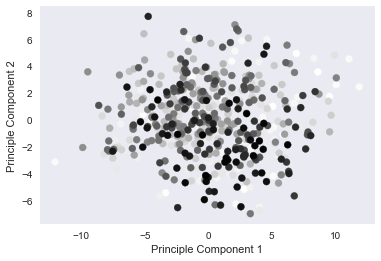

In [27]:
string = []
for i in range(25):
    i = 'Principle Component ' + str(i + 1)
    string.append(i)
    
yy = list(range(500))

index = list(range(5000))[1: 5000: 10]

X_pca = pca.fit(images_1d).transform(images_1d)
X_pca = X_pca[index]
xx = string

from pandas.tools.plotting import scatter_plot

# scatter plot the output, with the names created from the weights
ax = scatter_plot(pd.DataFrame(X_pca, columns=[xx]), xx[0], xx[1], c=yy)

A scatter plot of the PCA is also generated with after systematic samples method is performed. The 5000 sample size is still too large to be nicely observed in the scatterplot. And the 5000 sample has been sorted in the class names order. Therefore, a sysmatic sampling would be a easy method under this circumstance.

Different colors are labeled into the different targeted class. The 500 sampled instances in the scatterplot are also showing the chaos among the 10 target classes. 

<a id="RE"></a>
<a href="#top">Back to Top</a>
##  Reference

Kaggle. CIFAR-10 - Object Recognition in Images.
    https://www.kaggle.com/c/cifar-10  (Accessed 02/14/2017)